In [2]:
from toolz import *

import pandas as pd
import numpy as np
from scipy.special import expit

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style

style.use("ggplot")

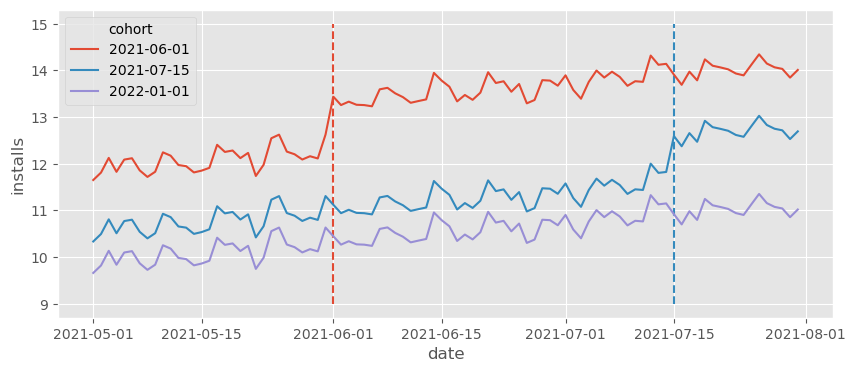

In [3]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df = pd.DataFrame(dict(
    date = np.tile(date, len(units)),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"] + d["w_seas"]/10,
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

In [4]:
formula = f"""installs ~ treat + C(unit) + C(date)"""

twfe_model = smf.ols(formula, data=df).fit()

twfe_model.params["treat"]

1.000000000000027

In [5]:
@curry
def demean(df, col_to_demean):
    return df.assign(**{col_to_demean: (df[col_to_demean]
                                        - df.groupby("unit")[col_to_demean].transform("mean")
                                        - df.groupby("date")[col_to_demean].transform("mean"))})


formula = f"""installs ~ treat"""
mod = smf.ols(formula,
              data=df
              .pipe(demean(col_to_demean="treat"))
              .pipe(demean(col_to_demean="installs")))

result = mod.fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-11.4580,1.25e-15,-9.2e+15,0.000,-11.458,-11.458
treat,1.0000,3.14e-15,3.18e+14,0.000,1.000,1.000


# NEW DID

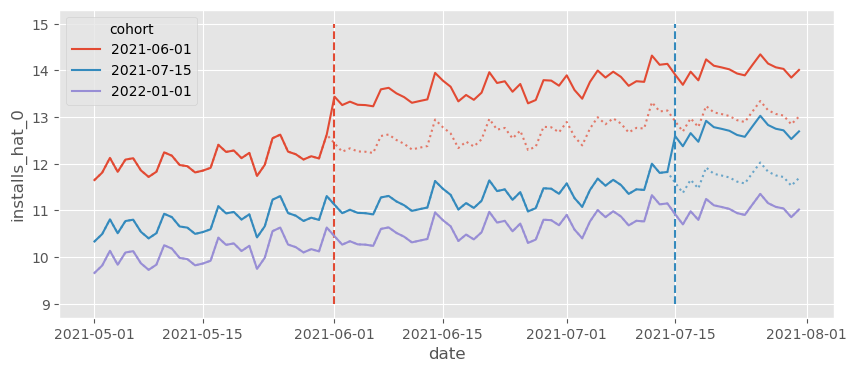

In [7]:
df_pred = df.assign(**{"installs_hat_0": twfe_model.predict(df.assign(**{"treat":0}))})
          

plt.figure(figsize=(10,4))
[plt.vlines(x=cohort, ymin=9, ymax=15, color=color, ls="dashed") for color, cohort in zip(["C0", "C1"], cohorts[:-1])]
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs_hat_0"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs_hat_0",
    hue="cohort",
    alpha=0.7,
    ls="dotted",
    legend=None
)
sns.lineplot(
    data=(df_pred
          .groupby(["cohort", "date"])["installs"]
          .mean()
          .reset_index()),
    x="date",
    y = "installs",
    hue="cohort",
);

In [18]:
date = pd.date_range("2021-05-01", "2021-07-31", freq="D")
cohorts = pd.to_datetime(["2021-06-01", "2021-07-15", "2022-01-01"]).date
units = range(1, 100+1)

np.random.seed(1)

df_heter = pd.DataFrame(dict(
    date = pd.to_datetime(np.tile(date.date, len(units))),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
).assign(
    y0 = lambda d: 10 + d["trend"] + 0.2*d["unit_fe"] + 0.05*d["time_fe"] + d["w_seas"]/50,
).assign(
    y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    installs = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)



/tmp/ipykernel_176/467655524.py:22: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  y1 = lambda d: d["y0"] + np.minimum(0.1*(np.maximum(0, (d["date"] - d["cohort"]).dt.days)), 1)


TypeError: unsupported operand type(s) for -: 'Timestamp' and 'datetime.date'

In [19]:
pd.DataFrame(dict(
    date = pd.to_datetime(np.tile(date.date, len(units))),
    unit = np.repeat(units, len(date)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(date)),
    unit_fe = np.repeat(np.random.normal(0, 5, size=len(units)), len(date)),
    time_fe = np.tile(np.random.normal(size=len(date)), len(units)),
    week_day = np.tile(date.weekday, len(units)),
    w_seas = np.tile(abs(5-date.weekday) % 7, len(units)),
)).assign(
    trend = lambda d: (d["date"] - d["date"].min()).dt.days/70,
    day = lambda d: (d["date"] - d["date"].min()).dt.days,
    treat = lambda d: (d["date"] >= d["cohort"]).astype(int),
)

,date,unit,cohort,unit_fe,time_fe,week_day,w_seas,trend,day,treat
0,2021-05-01,1,2022-01-01,5.653036,-2.457433,5,0,0.000000,0,0
1,2021-05-02,1,2022-01-01,5.653036,-0.525123,6,1,0.014286,1,0
2,2021-05-03,1,2022-01-01,5.653036,0.369591,0,5,0.028571,2,0
3,2021-05-04,1,2022-01-01,5.653036,-0.479216,1,4,0.042857,3,0
4,2021-05-05,1,2022-01-01,5.653036,0.320388,2,3,0.057143,4,0
...,...,...,...,...,...,...,...,...,...,...
9195,2021-07-27,100,2022-01-01,-6.141349,-1.297214,1,4,1.242857,87,0
9196,2021-07-28,100,2022-01-01,-6.141349,-0.068946,2,3,1.257143,88,0
9197,2021-07-29,100,2022-01-01,-6.141349,-0.607108,3,2,1.271429,89,0
9198,2021-07-30,100,2022-01-01,-6.141349,0.453924,4,1,1.285714,90,0
